# functions

library for all functions used in piepy preprocessing pipeline


NOTE from meeting on MOnday, Jun 13:

- combined rereferencing functions into one referencing function
- got stuck on SSD
    - Questions: use for oscillations? Noise? When appropriate for analysis or preprocessing?
    - currently: trying to use ssd for 60 hz filtering, how to apply filter to data?
    - how to turn output into raw object to continue with epoching?
    
- NEXT STEPS:
    - reach out to Andrew/Natalie for SSD help
    - continue pipeline/functions/modularizing

In [3]:
import os
import numpy as np

import mne
import mne_bids

In [4]:
path = '/Users/sydneysmith/Projects/piepy/data'

# first define the bids path
bids_path = mne_bids.BIDSPath(root=path, subject='1002', task='PrOPHEcy', datatype='ieeg', extension='edf') # task = 'PrOPHEcy'?

raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)

# Pick only the ECoG channels, removing the EKG channels
raw.pick_types(seeg=True, stim=True)

# Load the data
raw.load_data()

Reading 0 ... 1234047  =      0.000 ...  2410.248 secs...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_33183/4229720487.py:6: RuntimeWarning: The number of channels in the channels.tsv sidecar file (145) does not match the number of channels in the raw data file (258). Will not try to set channel names.
  raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)
/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_33183/4229720487.py:6: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: STI
  raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)
/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_33183/4229720487.py:6: RuntimeWarning: The unit for channel(s) DC1, TRIG has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)
/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_33183/4229720487.py:6: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['C63', 'C64', 'EKG1

<RawEDF | sub-1002_task-PrOPHEcy_ieeg.edf, 144 x 1234048 (2410.2 s), ~1.32 GB, data loaded>

In [ ]:
# rereferencing function

def set_reference(raw, reference_type='common_average'):
    """"""
    if reference_type == 'common_average':
        reref_raw = shank_avg_reference(raw, shank_list, trig_list)
        
    elif reference_type == 'bipolar':
        reref_raw = bipolar_reference(raw, shank_list, trig_list)
        
    elif reference_type == 'spatial':
        
        
            
        

In [ ]:
def shank_avg_reference(raw, shank_list, trig_list):
    """rereferemce to common average of each shank of electrodes
   
    Parameters
    ----------
    raw: instance of MNE Raw Object
    shank_list:
    trig_list:
    
    Returns
    -------
    reref_raw: MNE Raw Object
        contains both non-iEEG channels and rereferenced shanks
    """
    
    reref_shanks = [] # list to be populated with MNE raw objects that represent each rereferenced shank
    
    # MNE object that contains trigger channels
    trig_obj = raw.copy().pick_channels(trig_list, ordered=True)
    
    # loop through list of shanks
    for shank in shank_list:
        print(shank[0])
        shank_obj = raw.copy().pick_channels(shank, ordered=True) # get selection of raw with shank channels
        shank_obj.set_eeg_reference('average') # rereference to average
        reref_shanks.append(shank_obj) # append to list of rereferenced shank objects
        
    # concatenate lists of rereferenced objects
    reref_raw = reref_shanks[0].add_channels(reref_shanks[1:])
    reref_raw = reref_raw.add_channels([trig_obj], force_update_info=True) # add non-iEEG channels
        
    return reref_raw

In [ ]:
def bipolar_reference(raw, shank_list, trig_list):
    "get bipolar referenced object (each channel is referenced to adjacent channels on the shank)"
    
    # copy of raw for bipolar
    raw_bip_ref = raw.copy()
    for shank in shank_list:
        # get adjacent electode on shank
        raw_bip_ref = mne.set_bipolar_reference(raw_bip_ref, cathode=shank[0:-1], anode=shank[1:] )
        print(raw_bip_ref.info['ch_names'])
        
    return raw_bip_ref

Effective window size : 4.000 (s)


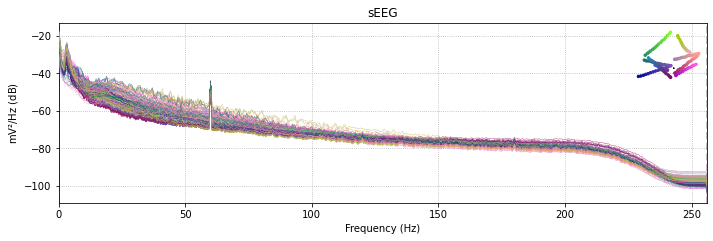

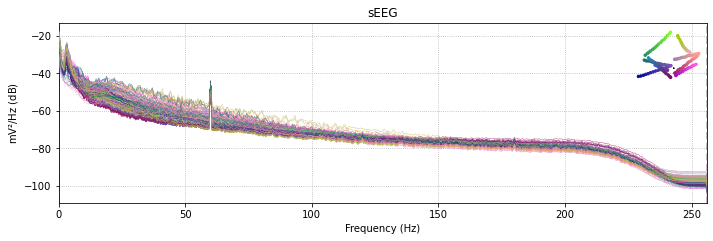

In [8]:
raw.plot_psd()

In [16]:
signal = [59,61]
noise = [1,62]


raw_ssd = raw.copy().pick_types(seeg=True)
ssd = mne.decoding.SSD(raw_ssd.info, 
             filt_params_signal=dict(l_freq=signal[0], h_freq=signal[1], l_trans_bandwidth=1, h_trans_bandwidth=1),
             filt_params_noise=dict(l_freq=noise[0], h_freq=noise[1], l_trans_bandwidth=1, h_trans_bandwidth=1),
             reg='empirical', 
             n_components=None, picks=None, sort_by_spectral_ratio=True,
             return_filtered=False, n_fft=None, cov_method_params=None, rank=None)
ssd.fit(X=raw_ssd.get_data())

# Transform
ssd_sources = ssd.transform(X=raw_ssd.get_data())

Setting up band-pass filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 58.50 Hz)
- Upper passband edge: 61.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 61.50 Hz)
- Filter length: 1691 samples (3.303 sec)

Setting up band-pass filter from 1 - 62 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 62.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 62.50 Hz)


In [17]:
# Get psd of SSD-filtered signals.
psd, freqs = mne.time_frequency.psd_array_welch(
    ssd_sources, sfreq=raw_ssd.info['sfreq'], n_fft=int(raw_ssd.info['sfreq']*2))

Effective window size : 2.000 (s)


In [14]:
import matplotlib.pyplot as plt

%matplotlib qt

In [20]:
below100 = freqs < 100
# for highlighting the freq. band of interest
bandfilt = (signal[0] <= freqs) & (freqs <= signal[1])
fig, ax = plt.subplots(1)
ax.loglog(freqs[below100], psd[0, below100], label='max SNR')
ax.loglog(freqs[below100], psd[1, below100], label='max 2 SNR')
ax.loglog(freqs[below100], psd[2, below100], label='max 3 SNR')
ax.loglog(freqs[below100], psd[-1, below100], label='min SNR')
ax.loglog(freqs[below100], psd[:, below100].mean(axis=0), label='mean')
ax.fill_between(freqs[bandfilt], 0, 10000, color='green', alpha=0.15)
ax.set_xlabel('log(frequency)')
ax.set_ylabel('log(power)')
ax.legend()

In [22]:
ssd_sources.shape

(142, 1234048)

In [23]:
# default to removing 1st noise component source

filt_60 = ssd.apply(ssd_sources)

In [25]:
filt_60.shape

(142, 1234048)

In [29]:
x = np.linspace(0,10,int(raw.info['sfreq']*10))


plt.plot(x, ssd_sources[0,:int(raw.info['sfreq']*10)])
plt.plot(x, filt_60[0,:int(raw.info['sfreq']*10)], alpha=0.7)

In [ ]:
signal = [15, 30]
noise =[12,33]

def spatial_reference(raw, signal_range, noise_range):
    """"""
    raw_ssd = raw_annotate.copy().pick_types(seeg=True)
    ssd = mne.decoding.SSD(raw_ssd.info, 
                 filt_params_signal=dict(l_freq=signal[0], h_freq=signal[1], l_trans_bandwidth=1, h_trans_bandwidth=1),
                 filt_params_noise=dict(l_freq=noise[0], h_freq=noise[1], l_trans_bandwidth=1, h_trans_bandwidth=1),
                 reg='empirical', 
                 n_components=None, picks=None, sort_by_spectral_ratio=True,
                 return_filtered=False, n_fft=None, cov_method_params=None, rank=None)
    ssd.fit(X=raw_ssd.get_data())
    
    # Transform
    ssd_sources = ssd.transform(X=raw_ssd.get_data())
    
    # generate 
    
    return spatial_ref